# Variational Auto Encoder
Strongly *inspired* by the tutorial of Alexander Van de Kleut [see here](https://avandekleut.github.io/vae/)

In [1]:
import torch
import torchvision
from variational_autoencoder import VariationalAutoencoder
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0) # ensures reproducibility

plt.rcParams['figure.dpi'] = 200
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

FIGURE_PATH = "figures/"

%load_ext autoreload
%autoreload 2

Load and normalise MNIST data

In [2]:
training_data = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST(
                            './data',
                            transform=torchvision.transforms.ToTensor(), # Normalises the data
                            train=True,  # Take training data only
                            download=True),
                    batch_size=128,
                    shuffle=True)

Plot some sample data

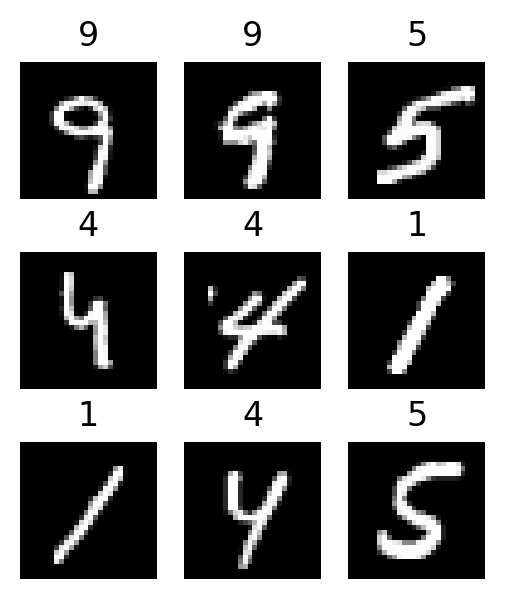

In [3]:
data_set = training_data.dataset
figure = plt.figure(figsize=(3, 3.5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data_set), size=(1,)).item()
    img, label = data_set[sample_idx]
    assert torch.min(img) >= 0 and torch.max(img) <= 1  # check normalisation
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Initialise auto encoder and specifying a two dimensional latent space

In [4]:
LATENT_DIMS = 2
autoencoder = VariationalAutoencoder(LATENT_DIMS).to(DEVICE)

loss_history = []

Training Loop using Adam optimiser:

In [5]:
def train(autoencoder: VariationalAutoencoder,
          data,
          epochs: int,
          loss_history: list) -> Tuple[VariationalAutoencoder, list]:
    opt = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    for _ in range(epochs):
        for x, _ in data:
            x = x.to(DEVICE) # send to GPU
            opt.zero_grad()
            mu_decoder = autoencoder(x)
            reconstruction_loss = ((x - mu_decoder)**2).sum()
            sigma_decoder = torch.exp(autoencoder.decoder.log_sigma)
            batch_size = x.shape[0]
            loss = reconstruction_loss / (2 * sigma_decoder**2) \
                    + autoencoder.encoder.kl \
                    + batch_size * 784 * torch.log(sigma_decoder) \
            # print(loss, batch_size * 784 * torch.log(sigma_decoder))
            # print(autoencoder.encoder.kl)
            loss_history.append(reconstruction_loss.item())
            loss.backward()
            opt.step()

    return autoencoder, loss_history

Train model parameters

In [6]:
# torch.autograd.set_detect_anomaly(True)
autoencoder, loss_history = train(autoencoder, training_data, epochs=1, loss_history=loss_history)

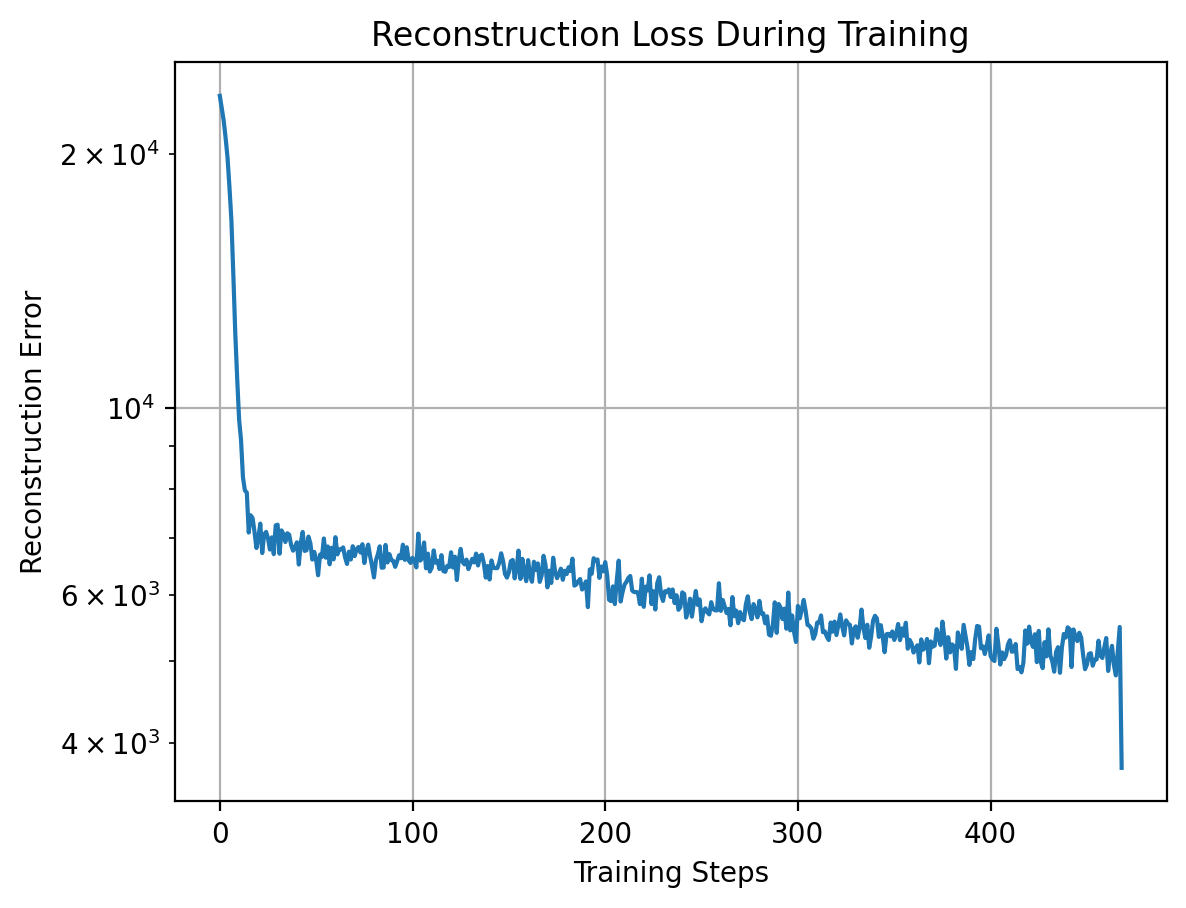

In [7]:
plt.plot(loss_history)
plt.yscale("log")
plt.grid(True)
plt.title("Reconstruction Loss During Training")
plt.ylabel("Reconstruction Error")
plt.xlabel("Training Steps")
plt.savefig(FIGURE_PATH + "loss.png")
plt.show()

In [8]:
print("Standard deviation of decoder distribution: ", torch.exp(autoencoder.decoder.log_sigma).item())

Standard deviation of decoder distribution:  0.6270630359649658


In [9]:
test_data = torch.utils.data.DataLoader(
                torchvision.datasets.MNIST('./data',
                        transform=torchvision.transforms.ToTensor(), # Normalises the data
                        train=False,  # Take training data only
                        download=True),
                batch_size=128,
                shuffle=True)

In [10]:
def plot_latent(autoencoder : VariationalAutoencoder, data):
    for i, (x, label) in enumerate(data):
        mu, _ = autoencoder.encoder(x.to(DEVICE))
        mu = mu.to('cpu').detach().numpy()
        plt.scatter(mu[:, 0], mu[:, 1], c=label, cmap='tab10')
    plt.colorbar()
    plt.grid(True)
    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")


In [11]:
def plot_reconstructed(autoencoder : VariationalAutoencoder, r0=(-4, 4), r1=(-4, 4), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(DEVICE)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")
    plt.title("Visualisation of Decoded Latent Space Grid")
    plt.savefig("vis_latent.png")

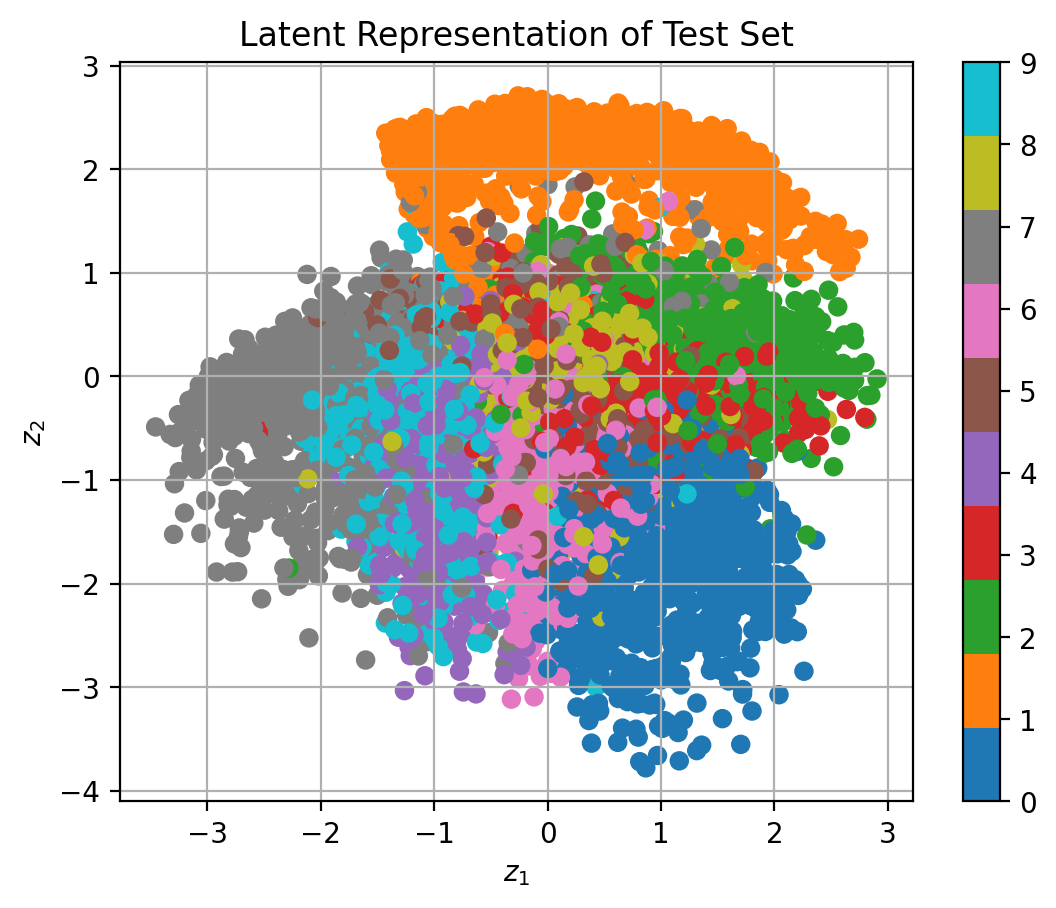

In [12]:
plot_latent(autoencoder, test_data)
plt.title("Latent Representation of Test Set")
plt.savefig(FIGURE_PATH + "latent_representation.png")
plt.show()

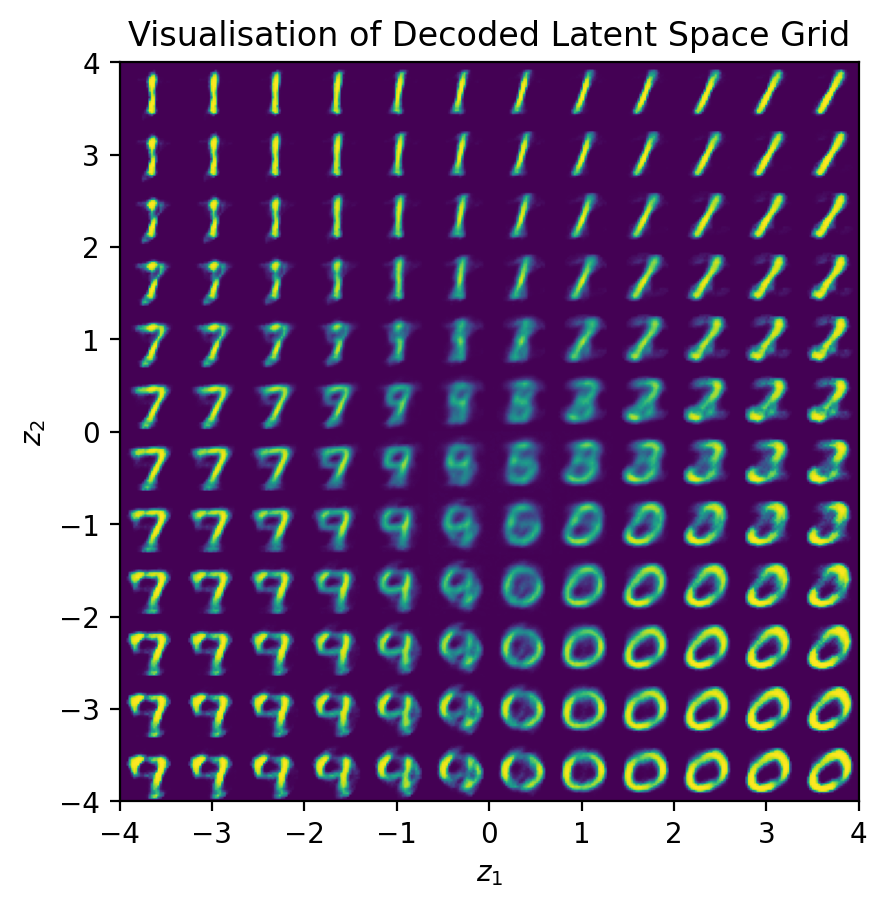

In [13]:
plot_reconstructed(autoencoder)

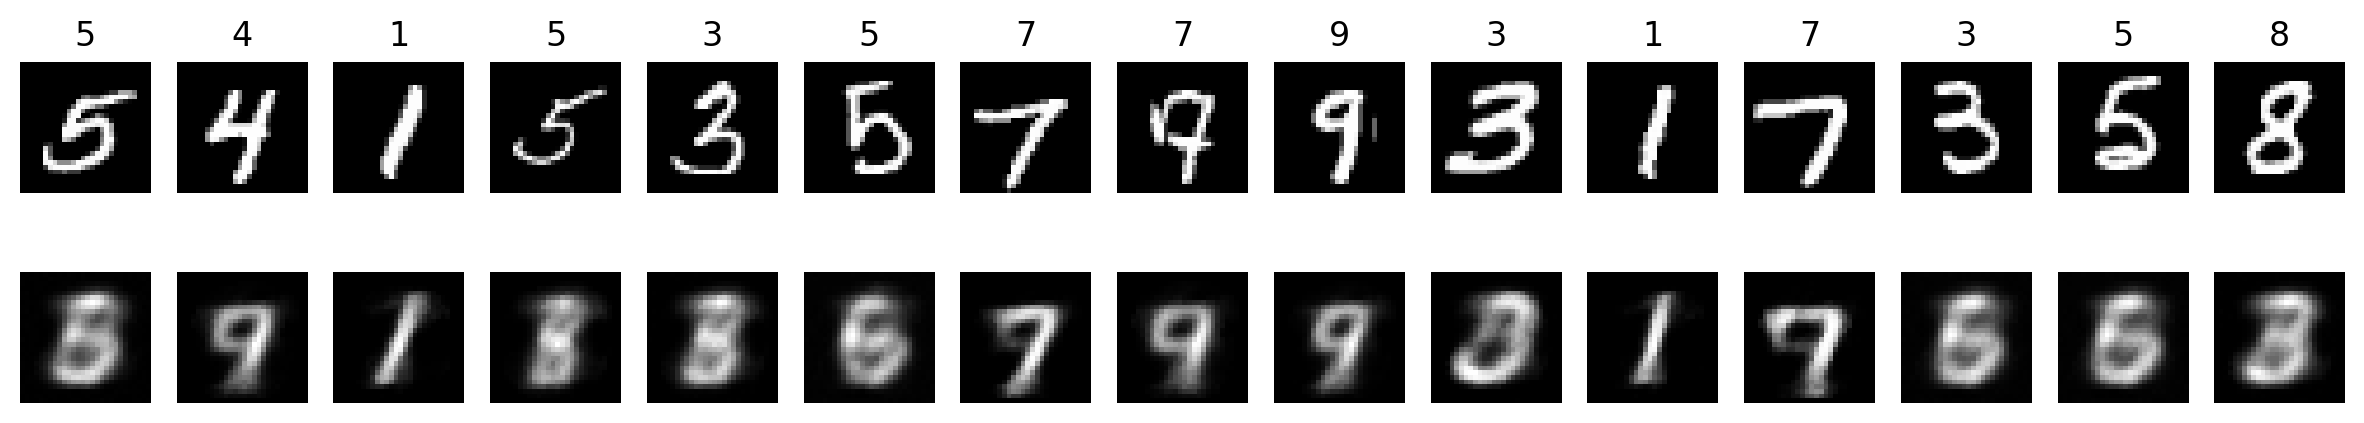

In [14]:
figure = plt.figure(figsize=(15, 2.5))
cols, rows = 15, 2
for i in range(1, cols + 1):
    sample_idx = torch.randint(len(data_set), size=(1,)).item()
    img, label = data_set[sample_idx]
    mu, _ = autoencoder.encoder(img.to(DEVICE))
    reconstructed_img = autoencoder.decoder(mu)
    # plot original
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    # plot reconstructed:
    figure.add_subplot(rows, cols, i + cols)
    plt.axis("off")
    plt.imshow(reconstructed_img.to("cpu").detach().squeeze(), cmap="gray")
plt.savefig(FIGURE_PATH + "reconstructed.png")
plt.show()

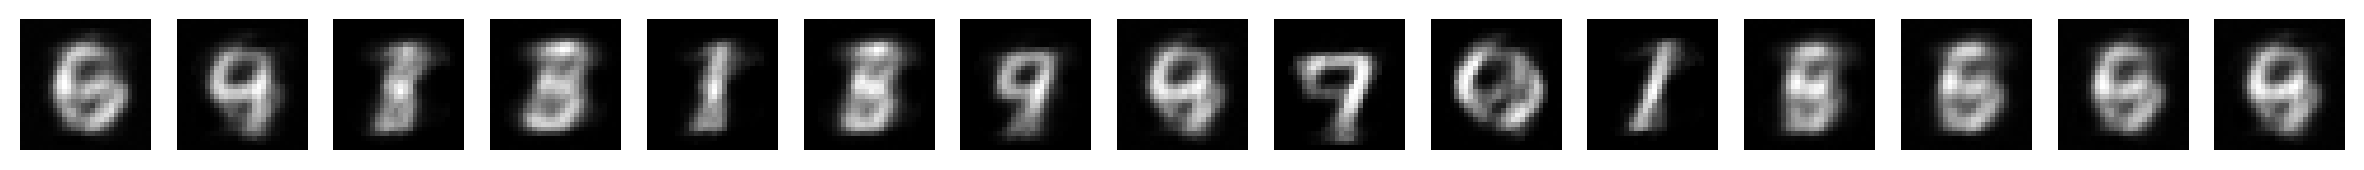

In [15]:
figure = plt.figure(figsize=(15, 2.5))
cols = 15
for i in range(1, cols + 1):
    mu = torch.randn(2).to(DEVICE) # sample mu from p(z) = N(0,1)
    reconstructed_img = autoencoder.decoder(mu)
    # plot generated:
    figure.add_subplot(1, cols, i)
    plt.axis("off")
    plt.imshow(reconstructed_img.to("cpu").detach().squeeze(), cmap="gray")
plt.savefig(FIGURE_PATH + "generated.png")
plt.show()